<a href="https://colab.research.google.com/github/mahfouz72/softmax-and-neural-network-mnist/blob/normalize-validation-data/softmax_and_neural_network_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# @title Imports
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

In [41]:
# @title Global vaiables
learning_rate = 0.01
epochs = 10
batch_size = 64
input_size = 28 * 28
number_of_classes = 10
l2_value = 0.000

**prepares the MNIST dataset for use in a PyTorch model. It loads the data, transforms it into tensors, splits it into training, validation, and test sets, and creates data loaders**

In [42]:
# @title Data Preparation

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='data/MNIST', train=True, transform=transform, download=True)
test_and_validation_dataset = datasets.MNIST(root='data/MNIST', train=False, transform=transform, download=True)

# Extract data and labels for train=False (Split into Validation and Test sets)
test_data = test_and_validation_dataset.data.numpy() / 255.0
test_labels = test_and_validation_dataset.targets.numpy()

val_data, test_data, val_labels, test_labels = train_test_split(
    test_data, test_labels, test_size=0.5, random_state=123
)

# Wrap NumPy arrays into TensorDataset
val_dataset = TensorDataset(torch.from_numpy(val_data).float(), torch.from_numpy(val_labels).long())
test_dataset = TensorDataset(torch.from_numpy(test_data).float(), torch.from_numpy(test_labels).long())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

**defines our Softmax Regression model, sets up the optimizer to adjust the model's parameters during training, and defines the loss function to guide the optimization process.**

In [43]:
# @title Softmax Regression Model

class SoftmaxRegression(torch.nn.Module):
    def __init__(self, input_size, number_of_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, number_of_classes)

    def forward(self, x):
      return self.linear(x)

model = SoftmaxRegression(input_size, number_of_classes)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_value)
loss_function = torch.nn.CrossEntropyLoss()

**drives the learning process of the Softmax Regression model. It feeds data to the model, calculates the error, adjusts the model's parameters to reduce the error, and evaluates the model's performance on a separate validation set.**

In [45]:
# @title Training
def train_model(model, optimizer, epochs, train_loader, val_loader):
  train_losses = []
  val_losses = []
  val_accuracies = []
  for epoch in range(epochs):
      model.train()  # just setting to training mode
      train_loss = 0.0

      for images, labels in train_loader:
          images = images.view(-1, input_size)

          outputs = model(images)
          loss = loss_function(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

      train_losses.append(train_loss / len(train_loader))


      model.eval()
      val_loss = 0.0
      correct_predictions = 0
      total_predictions = 0

      with torch.no_grad():
        for images, labels in val_loader:
          images = images.view(-1, input_size)

          outputs = model(images)
          loss = loss_function(outputs, labels)

          val_loss += loss.item()

          predicition = torch.max(outputs, 1)[1]
          correct_predictions += (predicition == labels).sum().item()
          total_predictions += labels.size(0)

      val_losses.append(val_loss / len(val_loader))
      val_accuracies.append(correct_predictions / total_predictions)


      print(f"Epoch {epoch+1}/{epochs}, "
            f"Train Loss: {train_losses[-1]:.4f}, "
            f"Val Loss: {val_losses[-1]:.4f}, "
            f"Val Accuracy: {val_accuracies[-1] * 100:.4f}%")

  return train_losses, val_losses, val_accuracies

  # return train_losses, val_losses, val_accuracies

# train_model(model, optimizer, epochs, train_loader, val_loader)

# Visualizations

***This function plots the training and validation loss across epochs to visualize the model's performance during training.***

In [ ]:
# Plot Training and Validation Loss

def plot_training_validation_loss(train_losses, val_losses):
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
  plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss Across Epochs')
  plt.legend()
  plt.show()


***This function evaluates the model's performance on the test set, calculates test loss and accuracy, and visualizes the confusion matrix.***


In [ ]:
# Plot Validation Accuracy
def plot_validation_accuracy(val_accuracies):
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Validation Accuracy Across Epochs')
  plt.legend()
  plt.show()


Epoch 1/10, Train Loss: 1.2521, Val Loss: 25.1553, Val Accuracy: 85.6000%
Epoch 2/10, Train Loss: 0.7059, Val Loss: 29.6736, Val Accuracy: 87.4800%
Epoch 3/10, Train Loss: 0.5807, Val Loss: 32.1322, Val Accuracy: 88.0400%
Epoch 4/10, Train Loss: 0.5207, Val Loss: 33.4784, Val Accuracy: 88.4000%
Epoch 5/10, Train Loss: 0.4839, Val Loss: 34.1713, Val Accuracy: 88.8400%
Epoch 6/10, Train Loss: 0.4587, Val Loss: 35.0412, Val Accuracy: 89.1600%
Epoch 7/10, Train Loss: 0.4399, Val Loss: 35.7458, Val Accuracy: 89.3600%
Epoch 8/10, Train Loss: 0.4253, Val Loss: 35.9860, Val Accuracy: 89.6600%
Epoch 9/10, Train Loss: 0.4135, Val Loss: 36.4168, Val Accuracy: 89.8000%
Epoch 10/10, Train Loss: 0.4038, Val Loss: 36.6064, Val Accuracy: 89.9800%


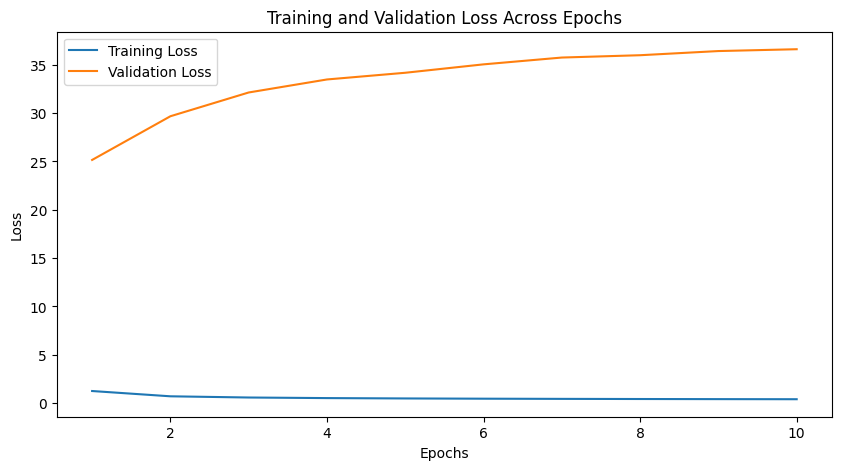

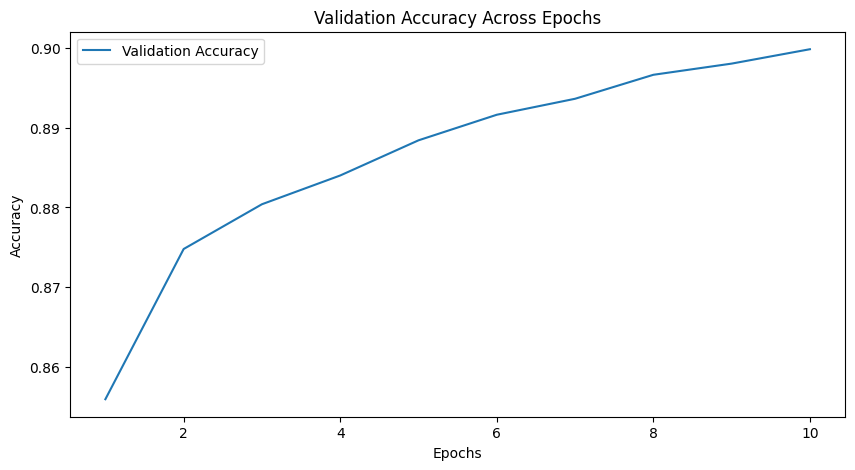

In [ ]:

model = SoftmaxRegression(input_size, number_of_classes)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_losses, val_losses, val_accuracies = train_model(model, optimizer, epochs, train_loader, val_loader)
plot_training_validation_loss(train_losses, val_losses)
plot_validation_accuracy(val_accuracies)

# Analysis

***This function visualizes the validation accuracy across epochs to track how well the model generalizes to unseen data during training.***

Test Loss: 35.9842, Test Accuracy: 89.66%


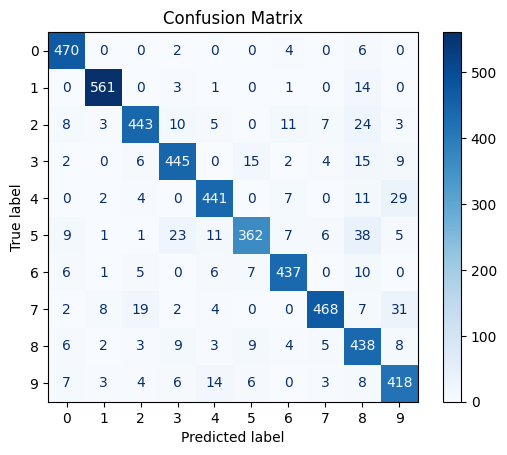

In [ ]:
# Evaluate Test Set Performance
def evaluate_test_set_performance():
  model.eval()
  test_loss = 0.0
  correct_predictions = 0
  total_predictions = 0
  all_predictions = []
  all_labels = []

  with torch.no_grad():
      for images, labels in test_loader:
          images = images.view(-1, input_size)
          outputs = model(images)
          loss = loss_function(outputs, labels)

          test_loss += loss.item()
          predictions = torch.max(outputs, 1)[1]
          correct_predictions += (predictions == labels).sum().item()
          total_predictions += labels.size(0)

          all_predictions.extend(predictions.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  test_accuracy = correct_predictions / total_predictions
  print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

  # Confusion Matrix
  cm = confusion_matrix(all_labels, all_predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(number_of_classes))
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.show()

evaluate_test_set_performance()

# Hyperparameter Analysis

***This code evaluates the model’s performance when trained with different learning rates to observe how the choice of learning rate affects convergence, accuracy, and loss.***

Testing with Learning Rate: 0.001
Epoch 1/10, Train Loss: 1.9233, Val Loss: 17.8701, Val Accuracy: 76.3200%
Epoch 2/10, Train Loss: 1.3950, Val Loss: 21.0670, Val Accuracy: 81.5400%
Epoch 3/10, Train Loss: 1.1216, Val Loss: 23.6307, Val Accuracy: 83.1400%
Epoch 4/10, Train Loss: 0.9633, Val Loss: 25.3082, Val Accuracy: 84.2000%
Epoch 5/10, Train Loss: 0.8610, Val Loss: 26.6310, Val Accuracy: 85.0400%
Epoch 6/10, Train Loss: 0.7896, Val Loss: 27.6520, Val Accuracy: 85.7000%
Epoch 7/10, Train Loss: 0.7366, Val Loss: 28.5989, Val Accuracy: 86.0200%
Epoch 8/10, Train Loss: 0.6956, Val Loss: 29.2988, Val Accuracy: 86.4600%
Epoch 9/10, Train Loss: 0.6627, Val Loss: 29.9662, Val Accuracy: 86.7800%
Epoch 10/10, Train Loss: 0.6358, Val Loss: 30.6493, Val Accuracy: 86.9800%


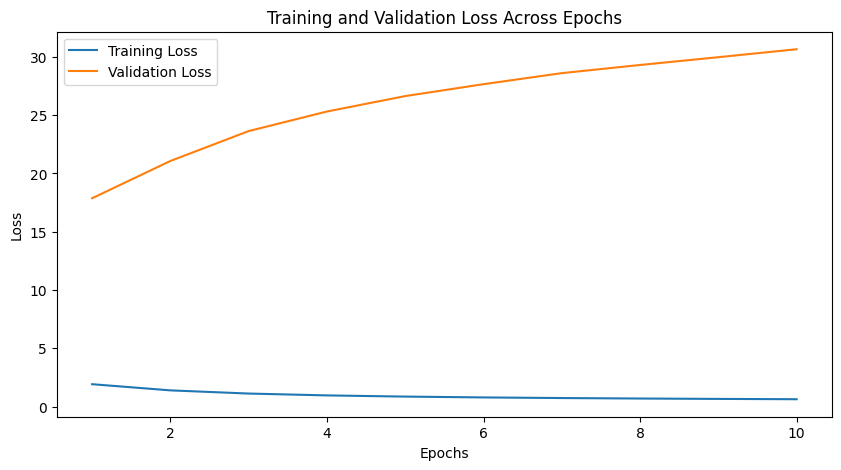

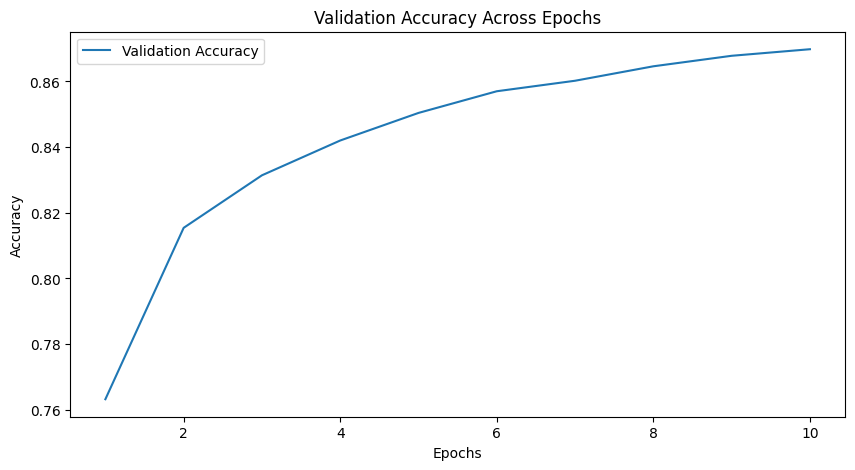

Test Loss: 30.6063, Test Accuracy: 86.16%


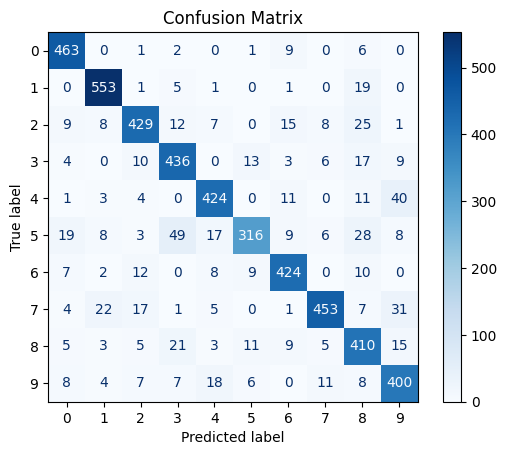

Testing with Learning Rate: 0.01
Epoch 1/10, Train Loss: 0.9775, Val Loss: 30.6803, Val Accuracy: 87.1400%
Epoch 2/10, Train Loss: 0.5512, Val Loss: 34.3230, Val Accuracy: 88.1800%
Epoch 3/10, Train Loss: 0.4720, Val Loss: 35.8211, Val Accuracy: 88.8000%
Epoch 4/10, Train Loss: 0.4333, Val Loss: 36.9597, Val Accuracy: 89.3200%
Epoch 5/10, Train Loss: 0.4092, Val Loss: 37.5629, Val Accuracy: 89.7600%
Epoch 6/10, Train Loss: 0.3925, Val Loss: 38.7874, Val Accuracy: 89.8400%
Epoch 7/10, Train Loss: 0.3799, Val Loss: 38.4722, Val Accuracy: 90.1600%
Epoch 8/10, Train Loss: 0.3700, Val Loss: 39.2503, Val Accuracy: 90.2800%
Epoch 9/10, Train Loss: 0.3618, Val Loss: 39.1049, Val Accuracy: 90.5000%
Epoch 10/10, Train Loss: 0.3550, Val Loss: 40.3215, Val Accuracy: 90.3800%


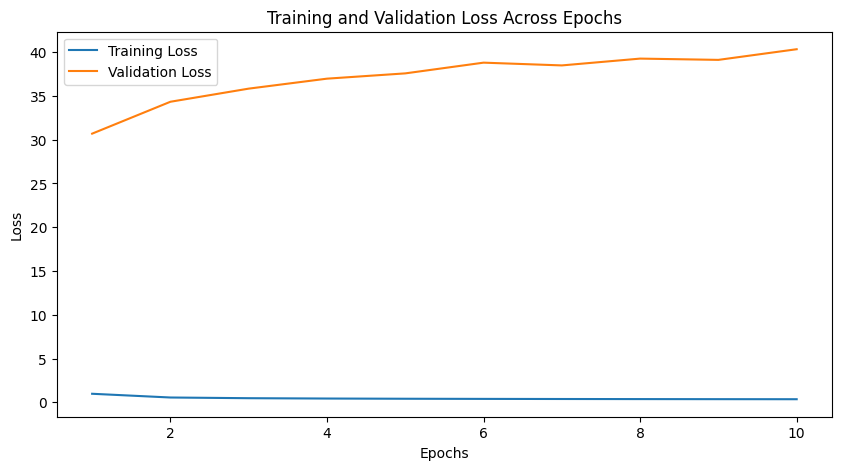

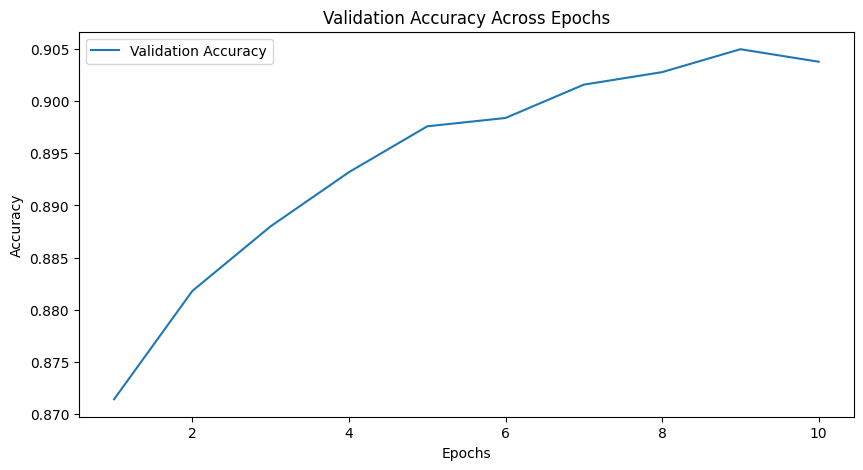

Test Loss: 38.8378, Test Accuracy: 90.32%


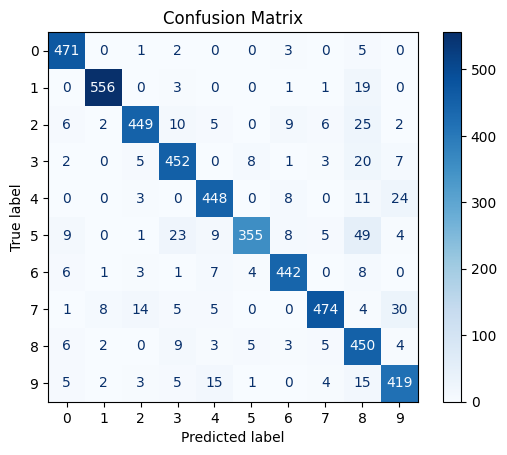

Testing with Learning Rate: 0.1
Epoch 1/10, Train Loss: 0.4779, Val Loss: 41.8181, Val Accuracy: 89.8600%
Epoch 2/10, Train Loss: 0.3365, Val Loss: 41.9601, Val Accuracy: 90.7400%
Epoch 3/10, Train Loss: 0.3142, Val Loss: 46.5100, Val Accuracy: 90.1400%
Epoch 4/10, Train Loss: 0.3024, Val Loss: 49.3272, Val Accuracy: 90.0000%
Epoch 5/10, Train Loss: 0.2942, Val Loss: 53.9130, Val Accuracy: 89.1000%
Epoch 6/10, Train Loss: 0.2887, Val Loss: 50.1598, Val Accuracy: 90.1600%
Epoch 7/10, Train Loss: 0.2844, Val Loss: 53.1747, Val Accuracy: 89.5400%
Epoch 8/10, Train Loss: 0.2807, Val Loss: 54.2235, Val Accuracy: 89.5400%
Epoch 9/10, Train Loss: 0.2779, Val Loss: 64.0526, Val Accuracy: 87.6600%
Epoch 10/10, Train Loss: 0.2756, Val Loss: 58.8592, Val Accuracy: 88.6400%


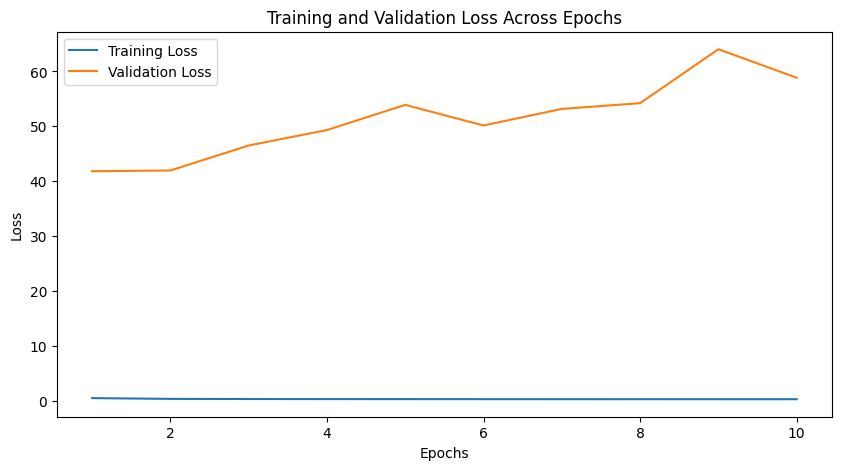

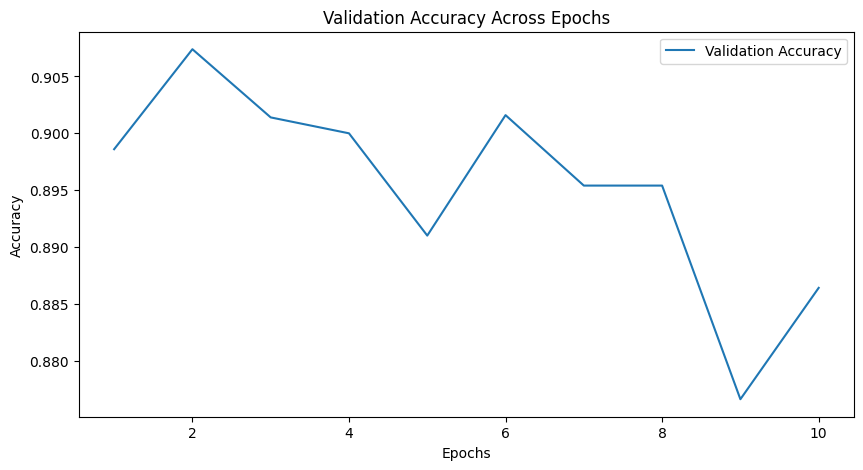

Test Loss: 61.2425, Test Accuracy: 88.44%


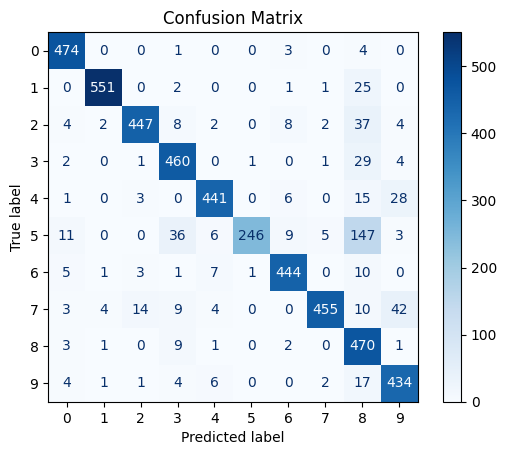

Testing with Learning Rate: 1.0
Epoch 1/10, Train Loss: 0.4307, Val Loss: 94.9043, Val Accuracy: 86.2200%
Epoch 2/10, Train Loss: 0.3302, Val Loss: 107.1294, Val Accuracy: 85.5200%
Epoch 3/10, Train Loss: 0.3200, Val Loss: 92.2670, Val Accuracy: 86.8600%
Epoch 4/10, Train Loss: 0.3150, Val Loss: 79.1250, Val Accuracy: 87.5800%
Epoch 5/10, Train Loss: 0.3067, Val Loss: 129.6475, Val Accuracy: 81.8600%
Epoch 6/10, Train Loss: 0.3044, Val Loss: 100.6399, Val Accuracy: 84.4400%
Epoch 7/10, Train Loss: 0.3041, Val Loss: 92.4808, Val Accuracy: 85.8800%
Epoch 8/10, Train Loss: 0.2981, Val Loss: 100.3892, Val Accuracy: 85.5800%
Epoch 9/10, Train Loss: 0.2977, Val Loss: 89.1643, Val Accuracy: 86.8400%
Epoch 10/10, Train Loss: 0.2954, Val Loss: 91.7621, Val Accuracy: 86.1000%


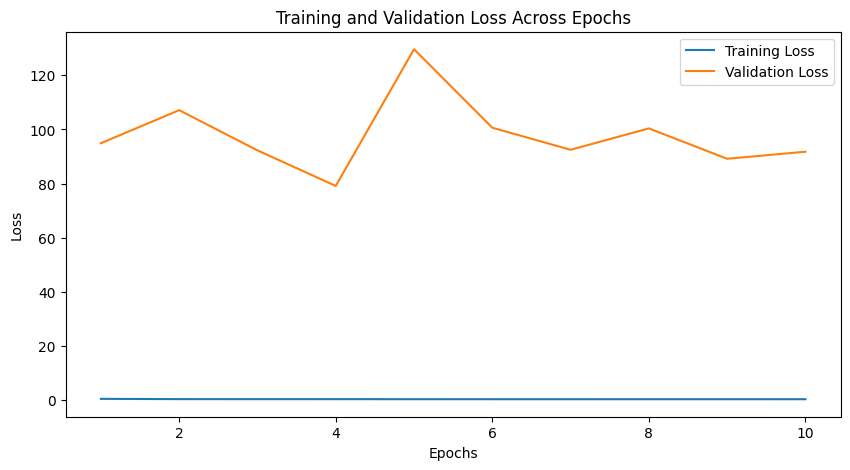

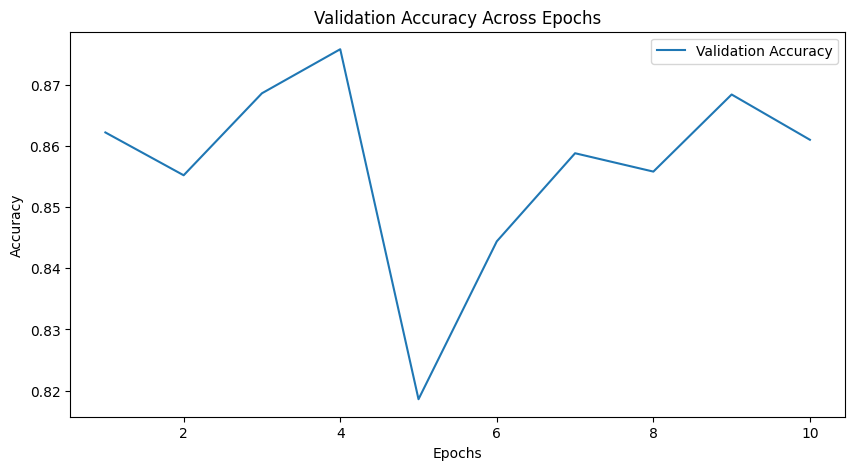

Test Loss: 94.4827, Test Accuracy: 86.12%


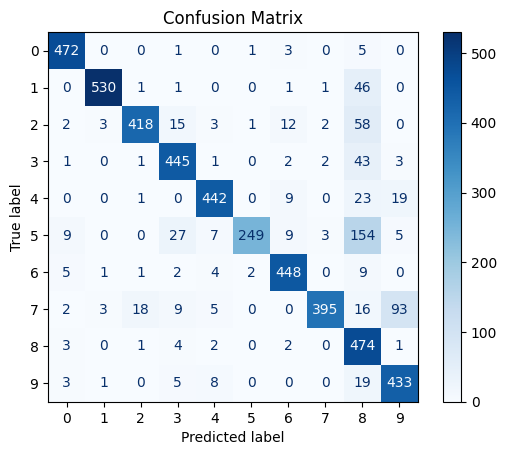

In [ ]:
# @title Changing learning rate
learning_rates = [0.001, 0.01, 0.1, 1.0]
results = {}

for lr in learning_rates:
    print(f"Testing with Learning Rate: {lr}")
    model = SoftmaxRegression(input_size, number_of_classes)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_losses, val_losses, val_accuracies = train_model(model, optimizer, epochs, train_loader, val_loader)
    plot_training_validation_loss(train_losses, val_losses)
    plot_validation_accuracy(val_accuracies)
    evaluate_test_set_performance()


***This code evaluates the impact of varying the batch size on training dynamics and model performance.***

Testing with Batch Size: 16
Epoch 1/10, Train Loss: 0.6122, Val Loss: 37.0540, Val Accuracy: 89.5600%
Epoch 2/10, Train Loss: 0.3898, Val Loss: 40.5411, Val Accuracy: 90.1000%
Epoch 3/10, Train Loss: 0.3541, Val Loss: 41.0524, Val Accuracy: 90.6600%
Epoch 4/10, Train Loss: 0.3361, Val Loss: 41.5042, Val Accuracy: 90.7400%
Epoch 5/10, Train Loss: 0.3241, Val Loss: 42.9055, Val Accuracy: 90.7400%
Epoch 6/10, Train Loss: 0.3158, Val Loss: 44.1265, Val Accuracy: 90.5600%
Epoch 7/10, Train Loss: 0.3093, Val Loss: 45.1394, Val Accuracy: 90.5400%
Epoch 8/10, Train Loss: 0.3042, Val Loss: 45.4204, Val Accuracy: 90.5800%
Epoch 9/10, Train Loss: 0.3000, Val Loss: 46.8254, Val Accuracy: 90.4000%
Epoch 10/10, Train Loss: 0.2964, Val Loss: 48.4975, Val Accuracy: 90.1200%


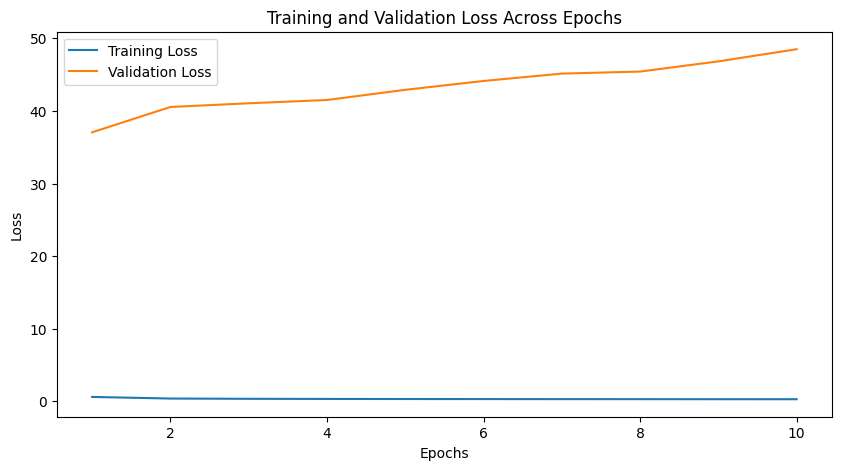

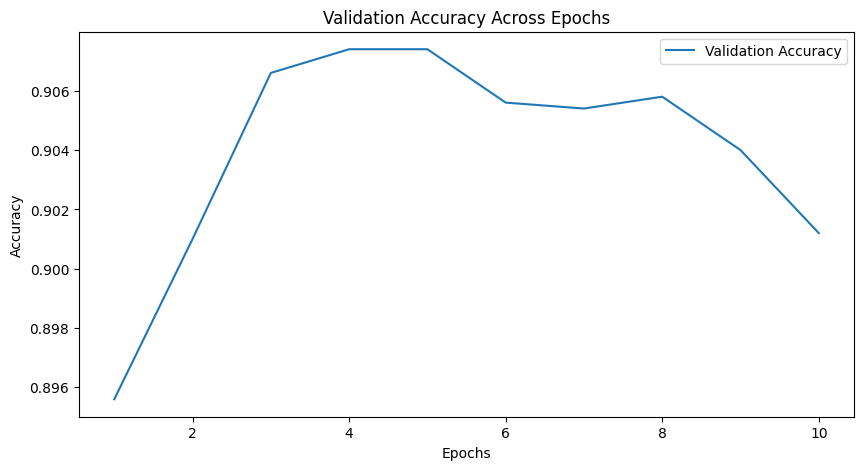

Test Loss: 49.4608, Test Accuracy: 89.50%


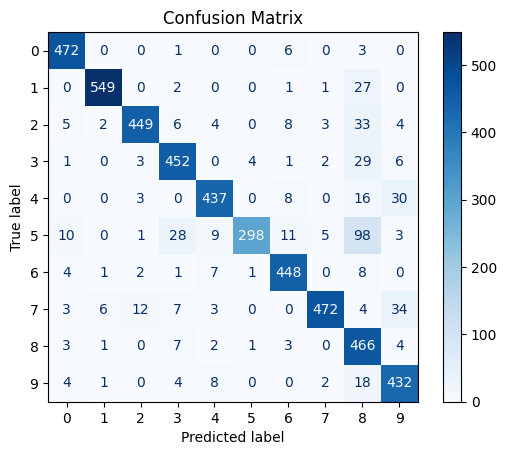

Testing with Batch Size: 32
Epoch 1/10, Train Loss: 0.7691, Val Loss: 34.5852, Val Accuracy: 88.2800%
Epoch 2/10, Train Loss: 0.4535, Val Loss: 37.1335, Val Accuracy: 89.5400%
Epoch 3/10, Train Loss: 0.4015, Val Loss: 38.2994, Val Accuracy: 89.9800%
Epoch 4/10, Train Loss: 0.3756, Val Loss: 38.9463, Val Accuracy: 90.2800%
Epoch 5/10, Train Loss: 0.3589, Val Loss: 40.7246, Val Accuracy: 90.2600%
Epoch 6/10, Train Loss: 0.3472, Val Loss: 39.6284, Val Accuracy: 90.7400%
Epoch 7/10, Train Loss: 0.3383, Val Loss: 40.9555, Val Accuracy: 90.7000%
Epoch 8/10, Train Loss: 0.3313, Val Loss: 42.2072, Val Accuracy: 90.6000%
Epoch 9/10, Train Loss: 0.3256, Val Loss: 42.7254, Val Accuracy: 90.6400%
Epoch 10/10, Train Loss: 0.3206, Val Loss: 42.6378, Val Accuracy: 90.7600%


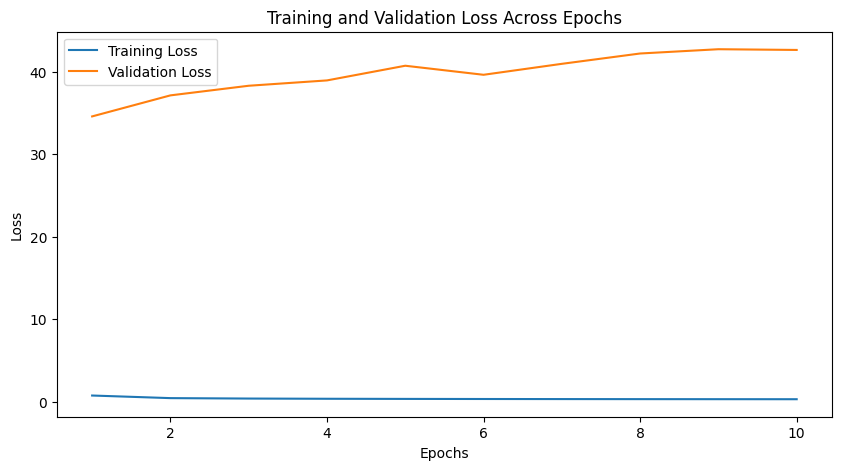

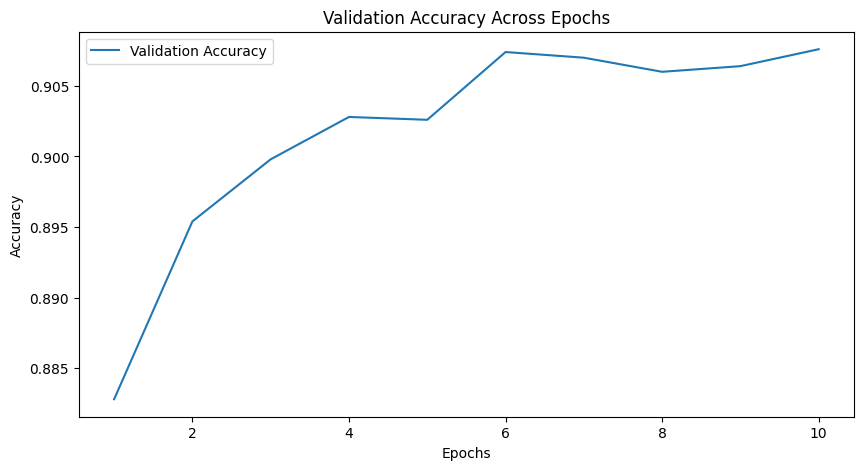

Test Loss: 41.9556, Test Accuracy: 90.56%


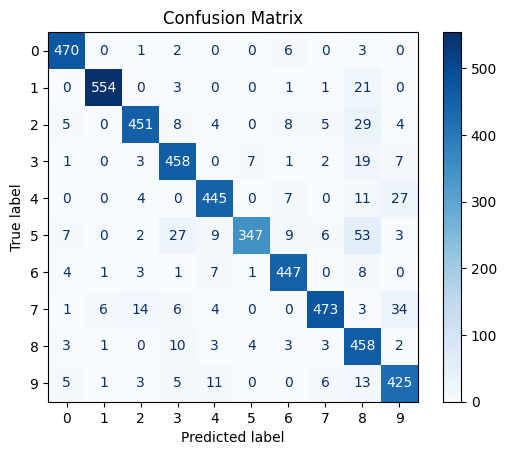

Testing with Batch Size: 64
Epoch 1/10, Train Loss: 0.9808, Val Loss: 30.2763, Val Accuracy: 87.1400%
Epoch 2/10, Train Loss: 0.5514, Val Loss: 33.8621, Val Accuracy: 88.2400%
Epoch 3/10, Train Loss: 0.4718, Val Loss: 35.7374, Val Accuracy: 88.8600%
Epoch 4/10, Train Loss: 0.4331, Val Loss: 37.0394, Val Accuracy: 89.3600%
Epoch 5/10, Train Loss: 0.4090, Val Loss: 37.4905, Val Accuracy: 89.6000%
Epoch 6/10, Train Loss: 0.3922, Val Loss: 37.6213, Val Accuracy: 90.0000%
Epoch 7/10, Train Loss: 0.3795, Val Loss: 38.3270, Val Accuracy: 90.1800%
Epoch 8/10, Train Loss: 0.3698, Val Loss: 38.8727, Val Accuracy: 90.3200%
Epoch 9/10, Train Loss: 0.3616, Val Loss: 39.9334, Val Accuracy: 90.2800%
Epoch 10/10, Train Loss: 0.3548, Val Loss: 39.1683, Val Accuracy: 90.5600%


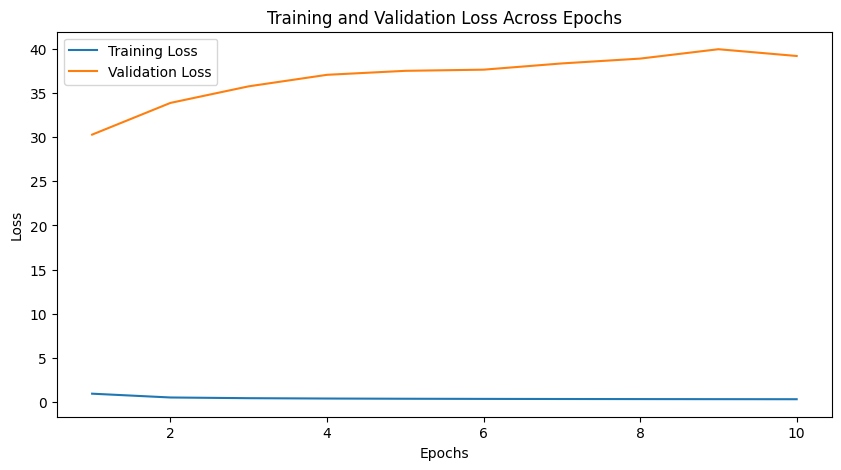

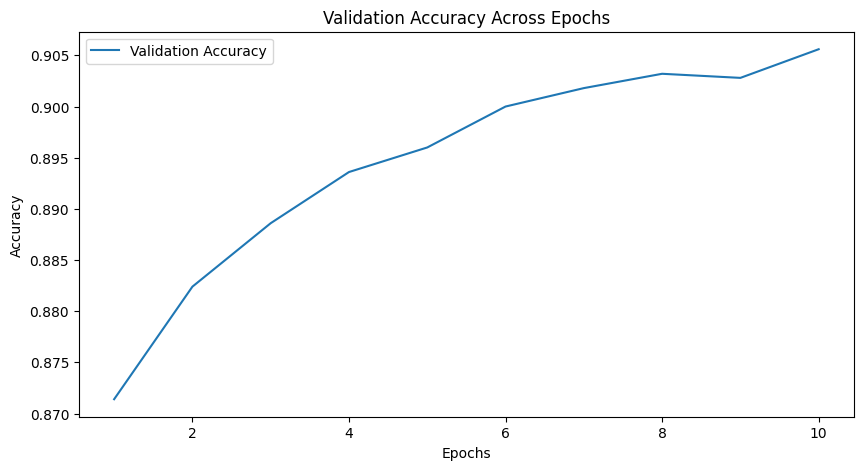

Test Loss: 38.1426, Test Accuracy: 90.50%


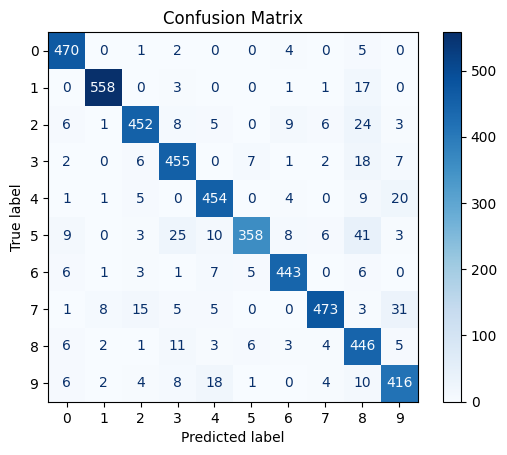

Testing with Batch Size: 128
Epoch 1/10, Train Loss: 1.2466, Val Loss: 26.3349, Val Accuracy: 85.0400%
Epoch 2/10, Train Loss: 0.7055, Val Loss: 30.3352, Val Accuracy: 87.1200%
Epoch 3/10, Train Loss: 0.5807, Val Loss: 32.3760, Val Accuracy: 87.6200%
Epoch 4/10, Train Loss: 0.5206, Val Loss: 33.5601, Val Accuracy: 88.1800%
Epoch 5/10, Train Loss: 0.4840, Val Loss: 34.5422, Val Accuracy: 88.7000%
Epoch 6/10, Train Loss: 0.4587, Val Loss: 35.2143, Val Accuracy: 89.0800%
Epoch 7/10, Train Loss: 0.4399, Val Loss: 35.6934, Val Accuracy: 89.3800%
Epoch 8/10, Train Loss: 0.4254, Val Loss: 36.1795, Val Accuracy: 89.5600%
Epoch 9/10, Train Loss: 0.4136, Val Loss: 36.4917, Val Accuracy: 89.8200%
Epoch 10/10, Train Loss: 0.4038, Val Loss: 37.2456, Val Accuracy: 89.6000%


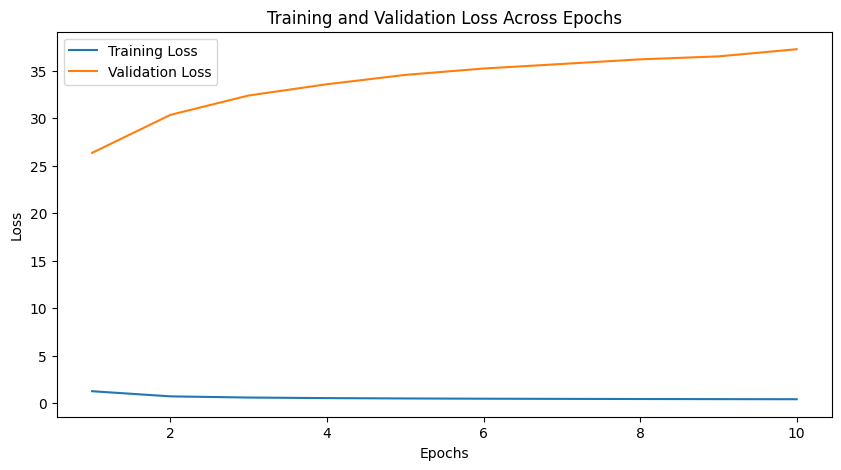

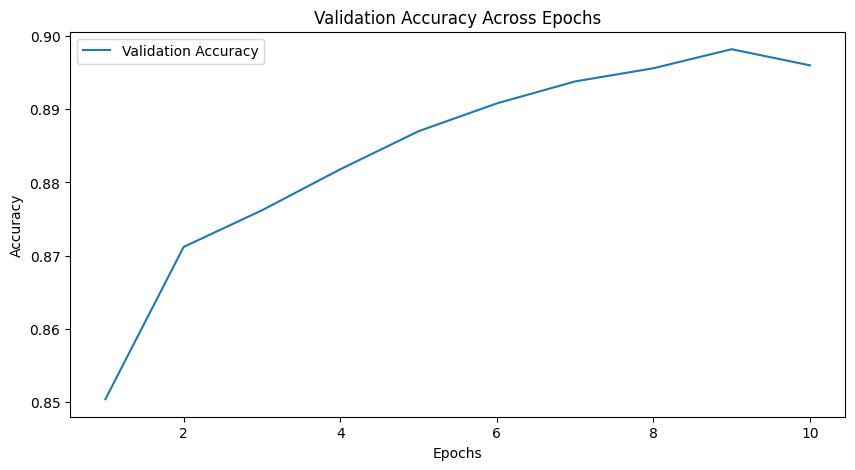

Test Loss: 36.7325, Test Accuracy: 89.60%


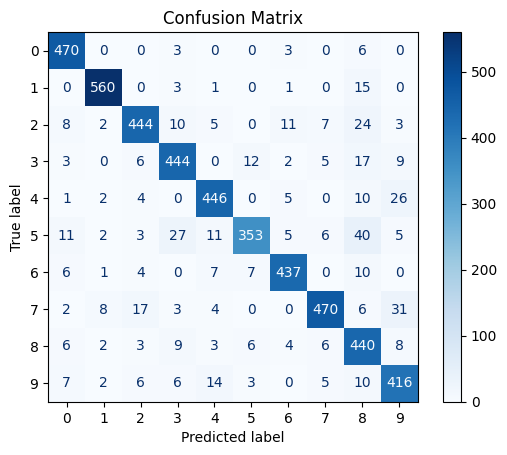

In [ ]:
# @title changing batch size
batch_sizes = [16, 32, 64, 128]

for batch in batch_sizes:
    print(f"Testing with Batch Size: {batch}")
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    model = SoftmaxRegression(input_size, number_of_classes)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    train_losses, val_losses, val_accuracies = train_model(model, optimizer, epochs, train_loader, val_loader)

    plot_training_validation_loss(train_losses, val_losses)
    plot_validation_accuracy(val_accuracies)
    evaluate_test_set_performance()


***This code evaluates the effect of L2 regularization (weight decay) on the model’s training and generalization.***

Testing with Weight Decay (L2 Regularization): 0.0
Epoch 1/10, Train Loss: 1.2592, Val Loss: 25.5264, Val Accuracy: 85.1200%
Epoch 2/10, Train Loss: 0.7058, Val Loss: 29.5695, Val Accuracy: 87.0400%
Epoch 3/10, Train Loss: 0.5799, Val Loss: 31.9737, Val Accuracy: 87.7800%
Epoch 4/10, Train Loss: 0.5196, Val Loss: 33.2127, Val Accuracy: 88.2600%
Epoch 5/10, Train Loss: 0.4830, Val Loss: 33.9472, Val Accuracy: 88.7400%
Epoch 6/10, Train Loss: 0.4578, Val Loss: 34.5290, Val Accuracy: 89.0600%
Epoch 7/10, Train Loss: 0.4392, Val Loss: 35.2234, Val Accuracy: 89.3800%
Epoch 8/10, Train Loss: 0.4246, Val Loss: 35.7786, Val Accuracy: 89.7000%
Epoch 9/10, Train Loss: 0.4127, Val Loss: 36.3704, Val Accuracy: 89.6200%
Epoch 10/10, Train Loss: 0.4030, Val Loss: 36.6135, Val Accuracy: 89.8600%


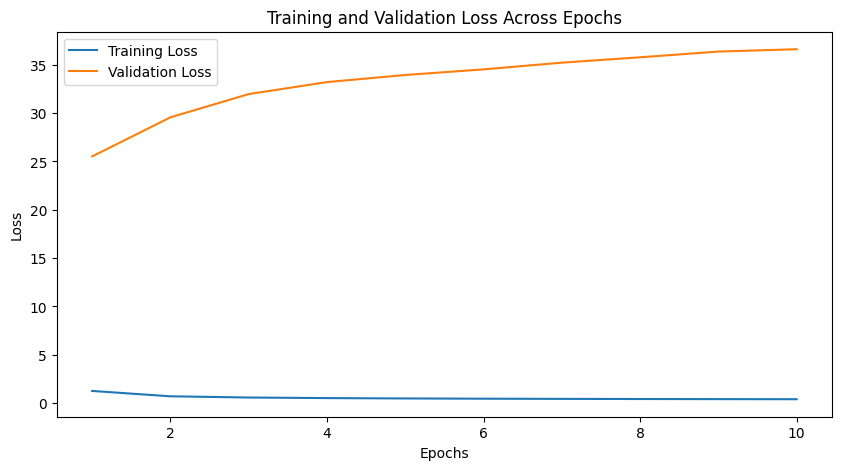

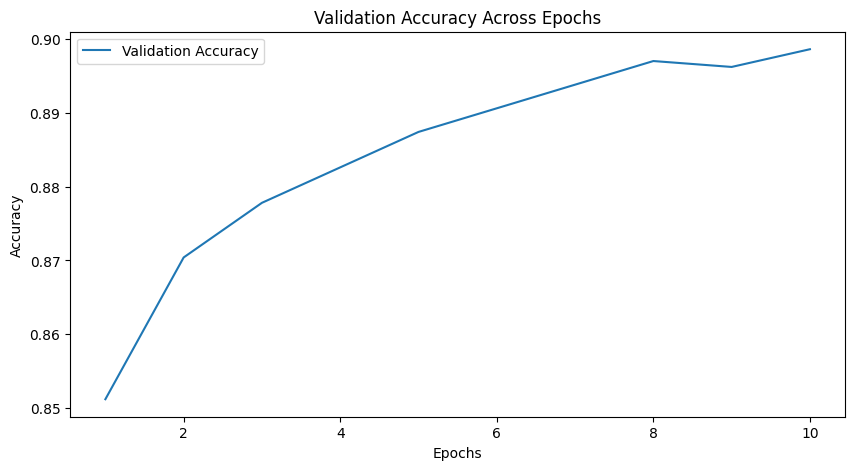

Test Loss: 36.6062, Test Accuracy: 89.52%


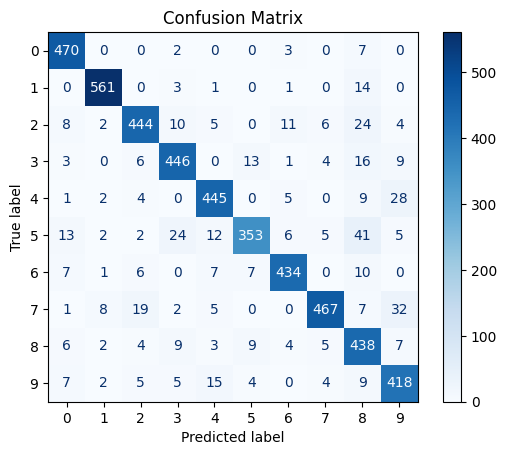

Testing with Weight Decay (L2 Regularization): 0.001
Epoch 1/10, Train Loss: 1.2622, Val Loss: 26.3096, Val Accuracy: 84.7600%
Epoch 2/10, Train Loss: 0.7118, Val Loss: 30.1581, Val Accuracy: 87.0200%
Epoch 3/10, Train Loss: 0.5856, Val Loss: 32.0925, Val Accuracy: 87.8000%
Epoch 4/10, Train Loss: 0.5251, Val Loss: 33.2925, Val Accuracy: 88.3200%
Epoch 5/10, Train Loss: 0.4883, Val Loss: 34.0693, Val Accuracy: 88.6200%
Epoch 6/10, Train Loss: 0.4631, Val Loss: 34.6503, Val Accuracy: 89.0600%
Epoch 7/10, Train Loss: 0.4443, Val Loss: 35.0345, Val Accuracy: 89.3600%
Epoch 8/10, Train Loss: 0.4299, Val Loss: 35.7435, Val Accuracy: 89.5600%
Epoch 9/10, Train Loss: 0.4182, Val Loss: 35.9033, Val Accuracy: 89.7400%
Epoch 10/10, Train Loss: 0.4085, Val Loss: 36.2651, Val Accuracy: 89.8200%


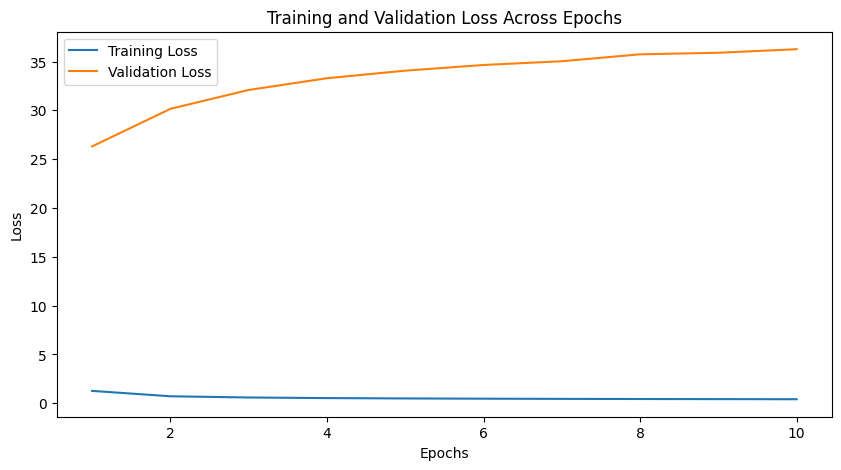

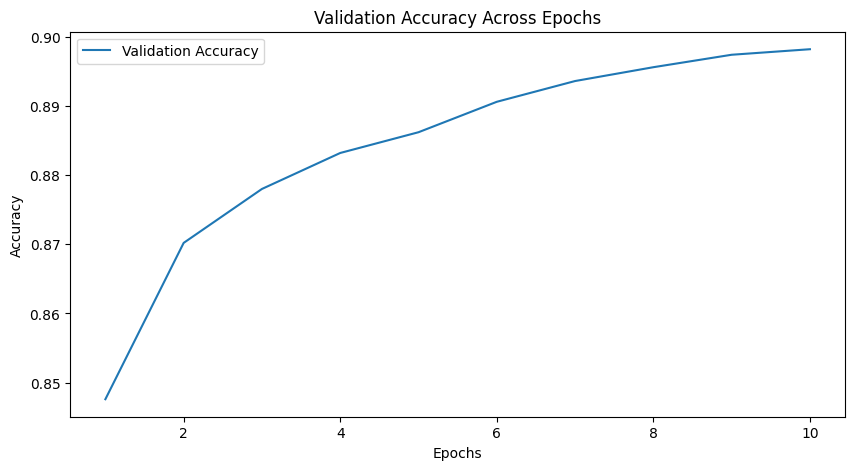

Test Loss: 35.9405, Test Accuracy: 89.50%


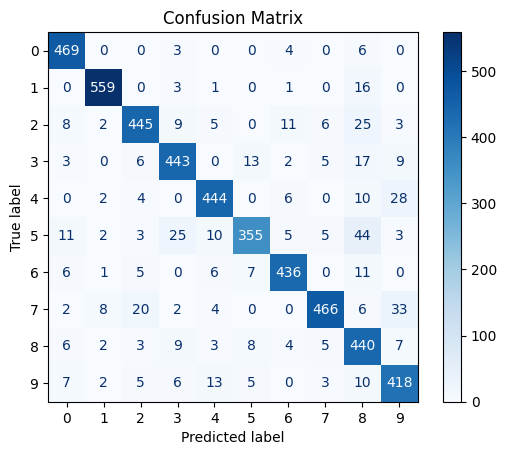

Testing with Weight Decay (L2 Regularization): 0.01
Epoch 1/10, Train Loss: 1.2621, Val Loss: 25.6140, Val Accuracy: 85.3400%
Epoch 2/10, Train Loss: 0.7229, Val Loss: 29.3361, Val Accuracy: 87.0400%
Epoch 3/10, Train Loss: 0.6032, Val Loss: 30.8376, Val Accuracy: 87.6800%
Epoch 4/10, Train Loss: 0.5474, Val Loss: 31.5766, Val Accuracy: 88.2800%
Epoch 5/10, Train Loss: 0.5145, Val Loss: 31.9529, Val Accuracy: 88.5400%
Epoch 6/10, Train Loss: 0.4925, Val Loss: 32.2943, Val Accuracy: 88.7000%
Epoch 7/10, Train Loss: 0.4769, Val Loss: 32.3973, Val Accuracy: 88.9600%
Epoch 8/10, Train Loss: 0.4651, Val Loss: 32.3580, Val Accuracy: 89.1200%
Epoch 9/10, Train Loss: 0.4562, Val Loss: 32.6229, Val Accuracy: 89.2600%
Epoch 10/10, Train Loss: 0.4490, Val Loss: 32.4097, Val Accuracy: 89.3800%


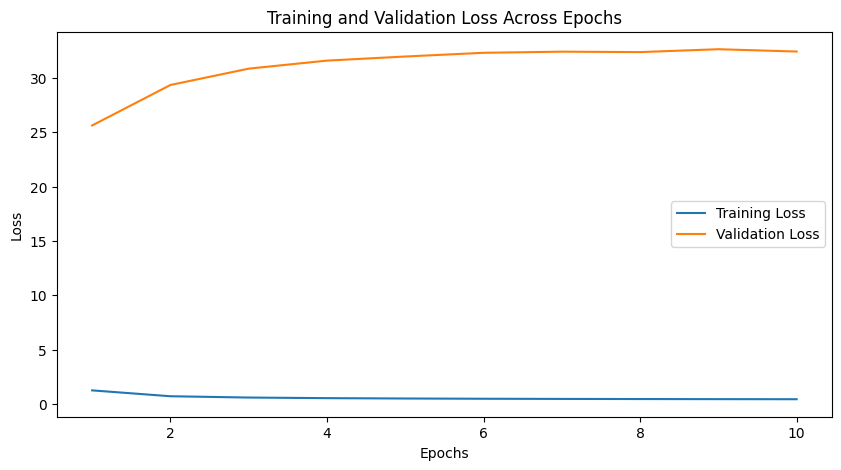

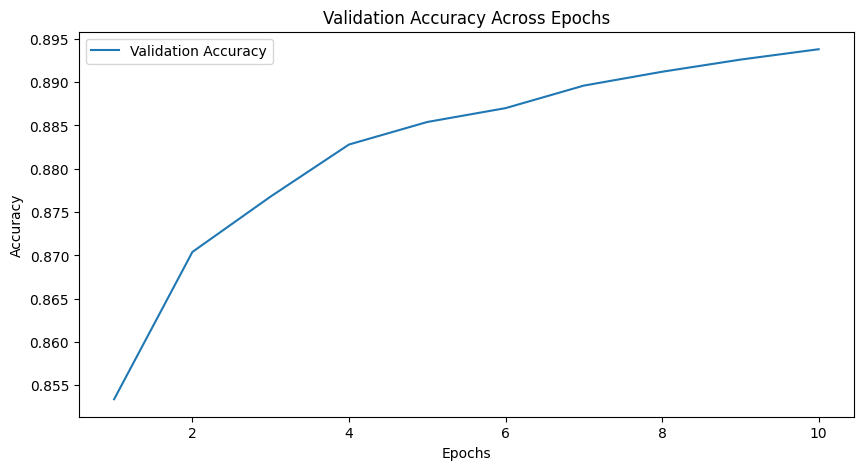

Test Loss: 31.8557, Test Accuracy: 89.42%


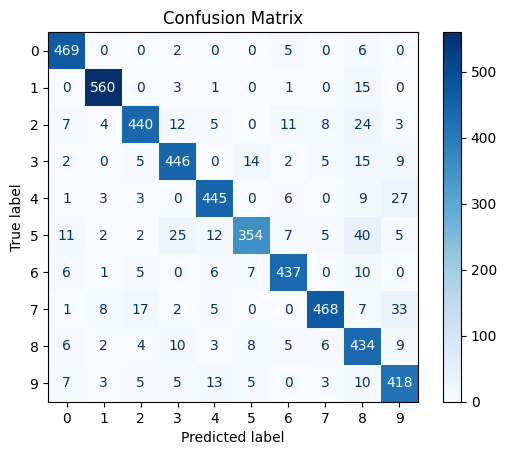

Testing with Weight Decay (L2 Regularization): 0.1
Epoch 1/10, Train Loss: 1.3244, Val Loss: 22.4008, Val Accuracy: 84.6600%
Epoch 2/10, Train Loss: 0.8696, Val Loss: 23.2112, Val Accuracy: 86.3000%
Epoch 3/10, Train Loss: 0.8018, Val Loss: 23.4238, Val Accuracy: 86.8600%
Epoch 4/10, Train Loss: 0.7821, Val Loss: 23.1978, Val Accuracy: 86.9600%
Epoch 5/10, Train Loss: 0.7749, Val Loss: 22.7464, Val Accuracy: 87.3800%
Epoch 6/10, Train Loss: 0.7726, Val Loss: 22.7489, Val Accuracy: 87.1600%
Epoch 7/10, Train Loss: 0.7715, Val Loss: 23.0421, Val Accuracy: 87.2000%
Epoch 8/10, Train Loss: 0.7710, Val Loss: 22.7768, Val Accuracy: 87.2000%
Epoch 9/10, Train Loss: 0.7706, Val Loss: 23.0054, Val Accuracy: 87.2000%
Epoch 10/10, Train Loss: 0.7705, Val Loss: 22.8354, Val Accuracy: 87.2200%


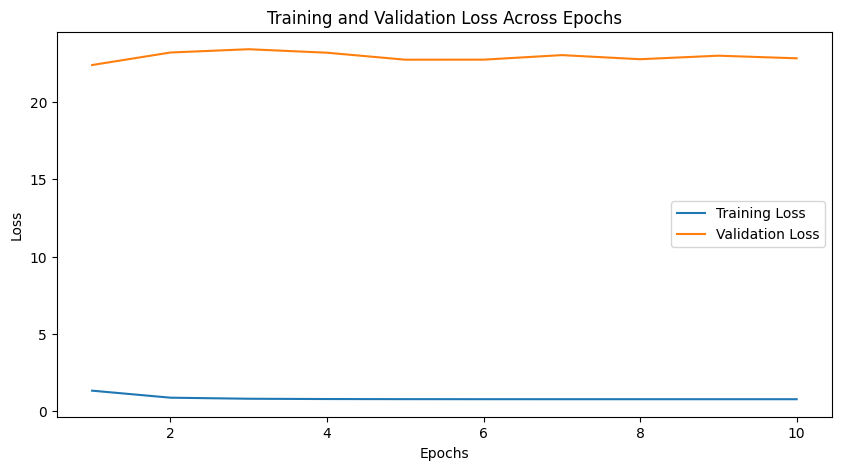

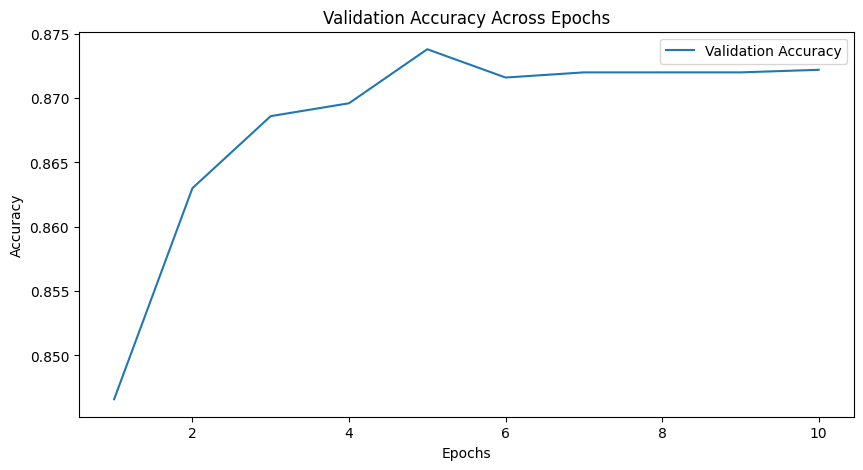

Test Loss: 22.9959, Test Accuracy: 86.50%


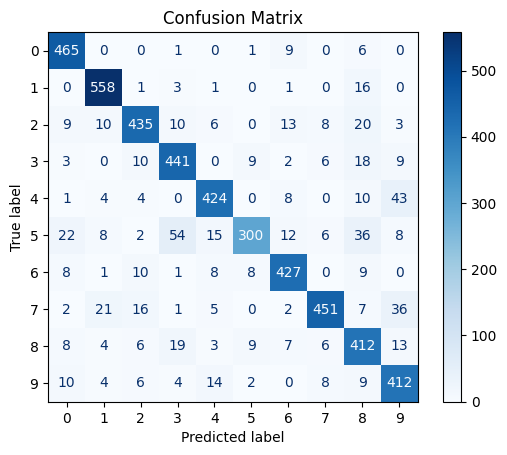

In [ ]:
# @title adding l2_regulariztion with different wieghts
weight_decays = [0.0, 0.001, 0.01, 0.1]

for wd in weight_decays:
    print(f"Testing with Weight Decay (L2 Regularization): {wd}")
    model = SoftmaxRegression(input_size, number_of_classes)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=wd)

    train_losses, val_losses, val_accuracies = train_model(model, optimizer, epochs, train_loader, val_loader)

    plot_training_validation_loss(train_losses, val_losses)
    plot_validation_accuracy(val_accuracies)
    evaluate_test_set_performance()